# Machine Learning For NLP : Prediction of Gender

# Table des matières

* [0. Imports et Packages](#chapter0)
* [1. Nettoyage des données](#chapter1)
* [2. Statistiques descriptives](#statistiques-descriptives)
* [3. Preprocessing](#preprocessing)
* [4. Modélisation](#modélisation)  
  * [4.1 Modèle naïf](#modèle-naïf)
  * [4.2 Modèle : Bert Base Uncased](#modele__bert_base_uncased)
  * [4.3 Modèle : Camembert base](#modèle--camembert-base)
  * [4.4 Modèle : DistilBERT](#modèle--distilbert)
  * [4.5 Données réduites](#données-réduites)


## 0. Imports et Packages <a class="anchor" id='chapter0'></a>

In [79]:
import numpy as np
import pandas as pd
import re
from preprocessing import cleaning_pipeline, concatenate_column_names
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from preprocessing import calculate_scores
# Importing necessary libraries
import torch
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
)
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset

In [80]:
df = pd.read_csv("transcriptions_with_sex.csv")
name_data = pd.read_csv("firstname_with_sex.csv", sep=";")

In [81]:
name_data.columns = ["prénom", "nombre hommes", "nombre femmes"]
name_data.head()

,prénom,nombre hommes,nombre femmes
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


## 1. Nettoyage des données <a class="anchor" id="chapter1"></a>

In [82]:
column_to_extract = "prediction"
columns_to_drop = ["subject_line", "groundtruth"]
cleaned_df = cleaning_pipeline(df, name_data, column_to_extract, columns_to_drop)

In [83]:
cleaned_df = cleaned_df[cleaned_df["sex"] != "ambigu"]

In [84]:
# Compter le nombre de NaN par colonne
na_counts = cleaned_df.isna().sum()

# Afficher le nombre de NaN par colonne
print(na_counts)

sex                  0
relation            84
profession         173
lieux_naissance     63
employeur          197
prénom               0
nom                 12
éducation          229
date_naissance       1
état_civil         196
nombre hommes       28
nombre femmes       28
dtype: int64


In [35]:
# Séparation des features (X) et de la cible (y)
X = cleaned_df.drop("sex", axis=1)  # Features (toutes les colonnes sauf 'sex')
y = cleaned_df["sex"]  # Cible (colonne 'sex')

# Split initial en train/validation + test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split du train/validation en train + validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=y_train_val,
)

# Affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de validation :", len(X_val))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 148
Taille de l'ensemble de validation : 37
Taille de l'ensemble de test : 47


In [12]:
# Compter le nombre de NaN par colonne
na_counts = X_train.isna().sum()

# Afficher le nombre de NaN par colonne
print(na_counts)

relation            66
profession         134
lieux_naissance     47
employeur          156
prénom               0
nom                 10
éducation          183
date_naissance       1
état_civil         157
nombre hommes       20
nombre femmes       20
dtype: int64


## 2. Statistiques descriptives <a id='statistiques-descriptives'></a>

### 2.1 Wordcloud sur la fréquence des genres des prénoms

In [13]:
name_data["female_freq"] = name_data["nombre femmes"] / (name_data["nombre hommes"] + name_data["nombre femmes"])

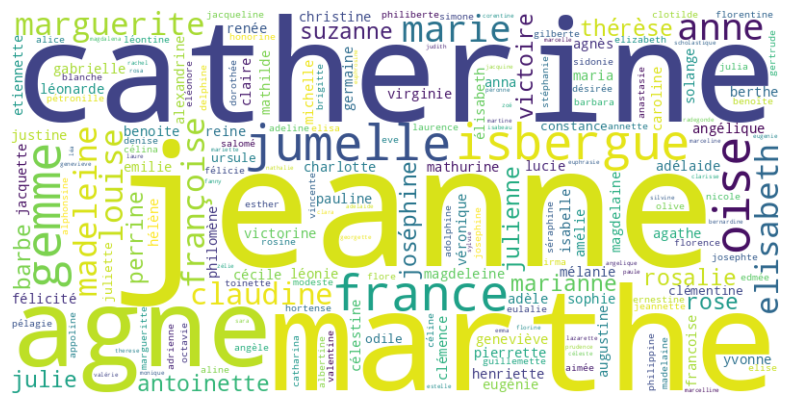

In [14]:
most_female_name = name_data[name_data["female_freq"] >= 0.5]
all_names = " ".join(most_female_name["prénom"].dropna())
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
#plt.title("Nuage de mots des prénoms le plus souvent féminin")
plt.show()

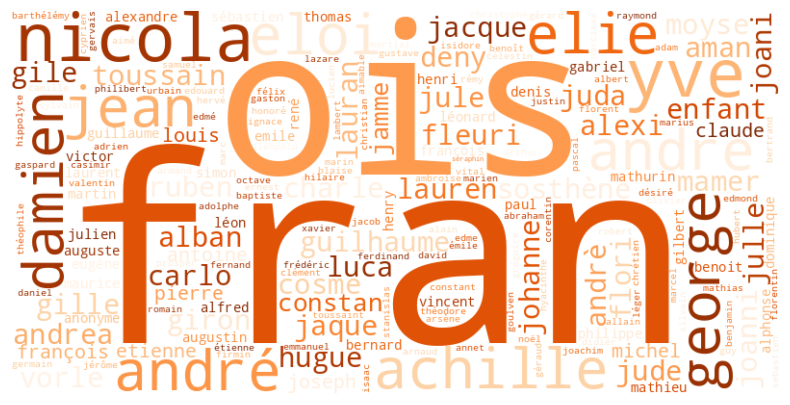

In [15]:
most_male_name = name_data[name_data["female_freq"] < 0.5]
all_names = " ".join(most_male_name["prénom"].dropna())
colormap = "Oranges"
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap=colormap
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.title("Nuage de mots des prénoms le plus souvent masculin")
plt.show()

### 2.2 Statistiques descriptives sur le données d'entraînements

In [71]:
df_train = X_train.copy()
df_train['target'] = y_train
df_homme = df_train[df_train['target'] == 'homme']  
df_femme = df_train[df_train["target"] == "femme"]

In [72]:
for col in df_train.columns:
    value_counts = df_train[col].value_counts()
    print(f"Value counts pour la colonne '{col}':\n{value_counts}\n")

Value counts pour la colonne 'relation':
chef          15
id             6
fils           4
F              4
enfant         3
Ch             3
sans           3
Ep             2
C              2
d              2
Chef           2
belle          2
femme          2
ch             2
a              1
fimme          1
employée       1
ép             1
io             1
inf            1
f              1
cullinière     1
argentière     1
chausne        1
domestique     1
noant          1
fomme          1
couturière     1
epre           1
frère          1
Rouher         1
fille          1
chemin         1
noraise        1
camprof        1
ouvrier        1
p              1
B              1
bent           1
petite         1
cultinière     1
Gonde          1
se             1
prof           1
chacon         1
Empl           1
Emp            1
sa             1
fins           1
coms           1
P              1
Name: relation, dtype: int64

Value counts pour la colonne 'profession':
id              4
p

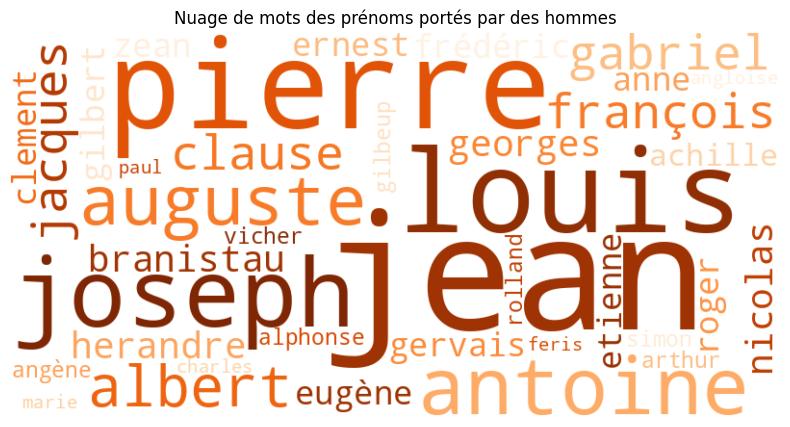

In [73]:
all_names = " ".join(df_homme["prénom"].dropna())
colormap = "Oranges"
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap=colormap
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des prénoms portés par des hommes")
plt.show()

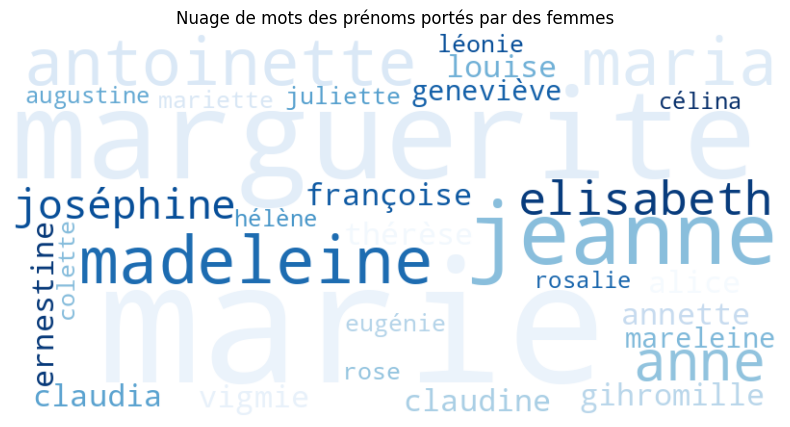

In [74]:
all_names = " ".join(df_femme["prénom"].dropna())
colormap = "Blues"
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap=colormap
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des prénoms portés par des femmes")
plt.show()

## 3. Preprocessing <a id='preprocessing'></a>

In [75]:
X_train_reduced = X_train[["prénom", "nom"]]
X_val_reduced = X_val[["prénom", "nom"]]
X_test_reduced = X_test[["prénom", "nom"]]

In [76]:
X_train['texte'] = X_train.apply(concatenate_column_names, axis=1)
X_val["texte"] = X_val.apply(concatenate_column_names, axis=1)
X_test["texte"] = X_test.apply(concatenate_column_names, axis=1)

X_train_reduced["texte"] = X_train_reduced.apply(
    concatenate_column_names, axis=1
)
X_val_reduced["texte"] = X_val_reduced.apply(concatenate_column_names, axis=1)
X_test_reduced["texte"] = X_test_reduced.apply(
    concatenate_column_names, axis=1
)

/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:43: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:43: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:43: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:43: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/var/folders/ts/w88f9trn42770xnr2_s8nchh0000gn/T/ipykernel_40218/4258509290.py:5: Se

## 4. Modélisation <a id='modélisation'></a>

### 4.1 Modèle naïf <a id='modèle-naïf'></a>


In [2]:
y_predict_train = pd.Series(
    [
        "homme" if male > female else "femme"
        for male, female in zip(X_train["nombre hommes"], X_train["nombre femmes"])
    ]
)

y_predict_test = pd.Series(
    [
        "homme" if male > female else "femme"
        for male, female in zip(X_test["nombre hommes"], X_test["nombre femmes"])
    ]
)

NameError: name 'pd' is not defined

In [ ]:
y_predict_train.value_counts()

femme    80
homme    68
dtype: int64

In [ ]:
# Calcul des scores pour les prédictions sur l'ensemble d'entraînement (train)
train_scores_df = calculate_scores(y_train, y_predict_train, label="homme")

# Calcul des scores pour les prédictions sur l'ensemble de test (test)
test_scores_df = calculate_scores(y_test, y_predict_test, label="homme")

# Concaténation des dataframes de scores
final_scores_df = pd.concat(
    [train_scores_df, test_scores_df], keys=["Train", "Test"]
)

# Affichage du dataframe des scores
print(final_scores_df)

             Accuracy  Precision  Recall  F1 Score
Train homme  0.918919        1.0    0.85  0.918919
Test  homme  0.936170        1.0    0.88  0.936170


In [56]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset

### 4.2 Modèle : Bert Base Uncased <a id='modele__bert_base_uncased'></a>

In [47]:
# Division des données en ensembles d'entraînement et de validation
train_texts = X_train['texte'].tolist()
val_texts = X_val["texte"].tolist()
test_texts = X_test['texte'].tolist()

# Conversion des cibles en labels numériques (0 pour femme, 1 pour homme)
train_targets = y_train.apply(lambda x: 1 if x == "homme" else 0).tolist()
val_targets = y_val.apply(lambda x: 1 if x == "homme" else 0).tolist()
test_targets = y_test.apply(lambda x: 1 if x == "homme" else 0).tolist()

In [64]:
# Initialisation du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)  # 2 labels: male, female

# Tokenisation des données
train_encodings = tokenizer(
    X_train["texte"].tolist(), truncation=True, padding=True
)
val_encodings = tokenizer(
    X_val["texte"].tolist(), truncation=True, padding=True
)
test_encodings = tokenizer(
    X_test["texte"].tolist(), truncation=True, padding=True
)

# Création des datasets PyTorch
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_targets),
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings["input_ids"]),
    torch.tensor(val_encodings["attention_mask"]),
    torch.tensor(val_targets),
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(test_targets),
)

# Paramètres d'entraînement
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Configuration de l'optimiseur
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(
            input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss:.4f}")

    # Évaluation du modèle sur l'ensemble de validation à chaque epoch
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(
                t.to(device) for t in batch
            )
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_preds)
    print(f"Epoch {epoch + 1}: Validation accuracy = {val_accuracy:.4f}")

# Évaluation finale du modèle sur l'ensemble de test
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds)

print(f"Final Test accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 score: {test_f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6740
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.5249
Epoch 2: Validation accuracy = 0.8919
Epoch 3: Average training loss = 0.2192
Epoch 3: Validation accuracy = 0.9459
Epoch 4: Average training loss = 0.1019
Epoch 4: Validation accuracy = 0.9189
Final Test accuracy: 0.9149
Final Test F1 score: 0.9231


### 4.3 Modèle : Camembert base <a id='modèle--camembert-base'></a>

In [33]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW

In [55]:
# Initialisation du tokenizer et du modèle CamemBERT
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", num_labels=2
)  # 2 labels: 0 (female), 1 (male)


# Tokenisation des données
train_encodings = tokenizer(
    X_train["texte"].tolist(), truncation=True, padding=True
)
val_encodings = tokenizer(
    X_val["texte"].tolist(), truncation=True, padding=True
)
test_encodings = tokenizer(
    X_test["texte"].tolist(), truncation=True, padding=True
)

# Création des datasets PyTorch
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_targets),
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings["input_ids"]),
    torch.tensor(val_encodings["attention_mask"]),
    torch.tensor(val_targets),
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(test_targets),
)

# Paramètres d'entraînement
batch_size = 16
num_epochs = 8
learning_rate = 2e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Configuration de l'optimiseur
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(
            input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss:.4f}")

    # Évaluation du modèle sur l'ensemble de validation à chaque epoch
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(
                t.to(device) for t in batch
            )
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_preds)
    print(f"Epoch {epoch + 1}: Validation accuracy = {val_accuracy:.4f}")

# Évaluation finale du modèle sur l'ensemble de test
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds)

print(f"Final Test accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 score: {test_f1:.4f}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6946
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6906
Epoch 2: Validation accuracy = 0.5405
Epoch 3: Average training loss = 0.6709
Epoch 3: Validation accuracy = 0.8378
Epoch 4: Average training loss = 0.5928
Epoch 4: Validation accuracy = 0.8378
Epoch 5: Average training loss = 0.4166
Epoch 5: Validation accuracy = 0.8649
Epoch 6: Average training loss = 0.3077
Epoch 6: Validation accuracy = 0.8378
Epoch 7: Average training loss = 0.2014
Epoch 7: Validation accuracy = 0.8919
Epoch 8: Average training loss = 0.1560
Epoch 8: Validation accuracy = 0.8649
Final Test accuracy: 0.9362


### 4.4 Modèle : DistilBERT <a id='modèle--distilbert'></a>

In [54]:
# Initializing the tokenizer and DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)  # 2 labels: 0 (female), 1 (male)

# Tokenisation des données
train_encodings = tokenizer(
    X_train["texte"].tolist(), truncation=True, padding=True
)
val_encodings = tokenizer(
    X_val["texte"].tolist(), truncation=True, padding=True
)
test_encodings = tokenizer(
    X_test["texte"].tolist(), truncation=True, padding=True
)

# Création des datasets PyTorch
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_targets),
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings["input_ids"]),
    torch.tensor(val_encodings["attention_mask"]),
    torch.tensor(val_targets),
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(test_targets),
)

# Paramètres d'entraînement
batch_size = 16
num_epochs = 8
learning_rate = 2e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Configuration de l'optimiseur
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(
            input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss:.4f}")

    # Évaluation du modèle sur l'ensemble de validation à chaque epoch
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(
                t.to(device) for t in batch
            )
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_preds)
    print(f"Epoch {epoch + 1}: Validation accuracy = {val_accuracy:.4f}")

# Évaluation finale du modèle sur l'ensemble de test
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds)

print(f"Final Test accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 score: {test_f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6912
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6762
Epoch 2: Validation accuracy = 0.5405
Epoch 3: Average training loss = 0.6032
Epoch 3: Validation accuracy = 0.7568
Epoch 4: Average training loss = 0.4229
Epoch 4: Validation accuracy = 0.9459
Epoch 5: Average training loss = 0.1773
Epoch 5: Validation accuracy = 0.9189
Epoch 6: Average training loss = 0.1155
Epoch 6: Validation accuracy = 0.9189
Epoch 7: Average training loss = 0.0779
Epoch 7: Validation accuracy = 0.9459
Epoch 8: Average training loss = 0.0653
Epoch 8: Validation accuracy = 0.9459
Final Test accuracy: 0.9362


### 4.5 Données réduites <a id='données-réduites'></a>

In [70]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
)
from sklearn.metrics import accuracy_score, f1_score

# Initializing the tokenizer and DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)  # 2 labels: 0 (female), 1 (male)

# Tokenisation des données pour X_train_reduced
train_encodings = tokenizer(
    X_train_reduced["texte"].tolist(), truncation=True, padding=True
)
val_encodings = tokenizer(
    X_val_reduced["texte"].tolist(), truncation=True, padding=True
)
test_encodings = tokenizer(
    X_test_reduced["texte"].tolist(), truncation=True, padding=True
)

# Création des datasets PyTorch pour X_train_reduced
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(
        train_targets
    ),  # Assurez-vous d'avoir défini train_targets correctement
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings["input_ids"]),
    torch.tensor(val_encodings["attention_mask"]),
    torch.tensor(
        val_targets
    ),  # Assurez-vous d'avoir défini val_targets correctement
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(
        test_targets
    ),  # Assurez-vous d'avoir défini test_targets correctement
)

# Paramètres d'entraînement
batch_size = 16
num_epochs = 3
learning_rate = 1e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Configuration de l'optimiseur
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(
            input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss:.4f}")

    # Évaluation du modèle sur l'ensemble de validation à chaque epoch
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = tuple(
                t.to(device) for t in batch
            )
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_preds)
    print(f"Epoch {epoch + 1}: Validation accuracy = {val_accuracy:.4f}")

# Évaluation finale du modèle sur l'ensemble de test
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true, test_preds)
test_f1 = f1_score(test_true, test_preds)

print(f"Final Test accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 score: {test_f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6869
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6592
Epoch 2: Validation accuracy = 0.6216
Epoch 3: Average training loss = 0.5398
Epoch 3: Validation accuracy = 0.9459
Final Test accuracy: 0.8723
Final Test F1 score: 0.8929
